In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Defining the column names
column_names = ['unit_nr', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

In [2]:
# Loading training data
train_path = os.path.join('..', 'data', 'FD001', 'train_FD001.txt')

# Using a separator for space-delimited files
train_df = pd.read_csv(train_path, sep='\\s+', header=None, names=column_names)
train_df.dropna(axis=1, how='all', inplace=True)

# Loading test data
test_path = os.path.join('..', 'data', 'FD001', 'test_FD001.txt')
test_df = pd.read_csv(test_path, sep='\\s+', header=None, names=column_names)
test_df.dropna(axis=1, how='all', inplace=True)

print("Train and Test data loaded successfully")

Train and Test data loaded successfully


--- Sensor Standard Deviation (Train Data) ---
sensor_1     0.000000e+00
sensor_10    0.000000e+00
sensor_19    0.000000e+00
sensor_18    0.000000e+00
sensor_16    1.387812e-17
sensor_5     1.776400e-15
sensor_6     1.388985e-03
sensor_15    3.750504e-02
sensor_8     7.098548e-02
sensor_13    7.191892e-02
sensor_21    1.082509e-01
sensor_20    1.807464e-01
sensor_11    2.670874e-01
sensor_2     5.000533e-01
sensor_12    7.375534e-01
sensor_7     8.850923e-01
sensor_17    1.548763e+00
sensor_3     6.131150e+00
sensor_4     9.000605e+00
sensor_14    1.907618e+01
sensor_9     2.208288e+01
dtype: float64

Individual Sensor Plots for Engine ID: 1 (Train Data)


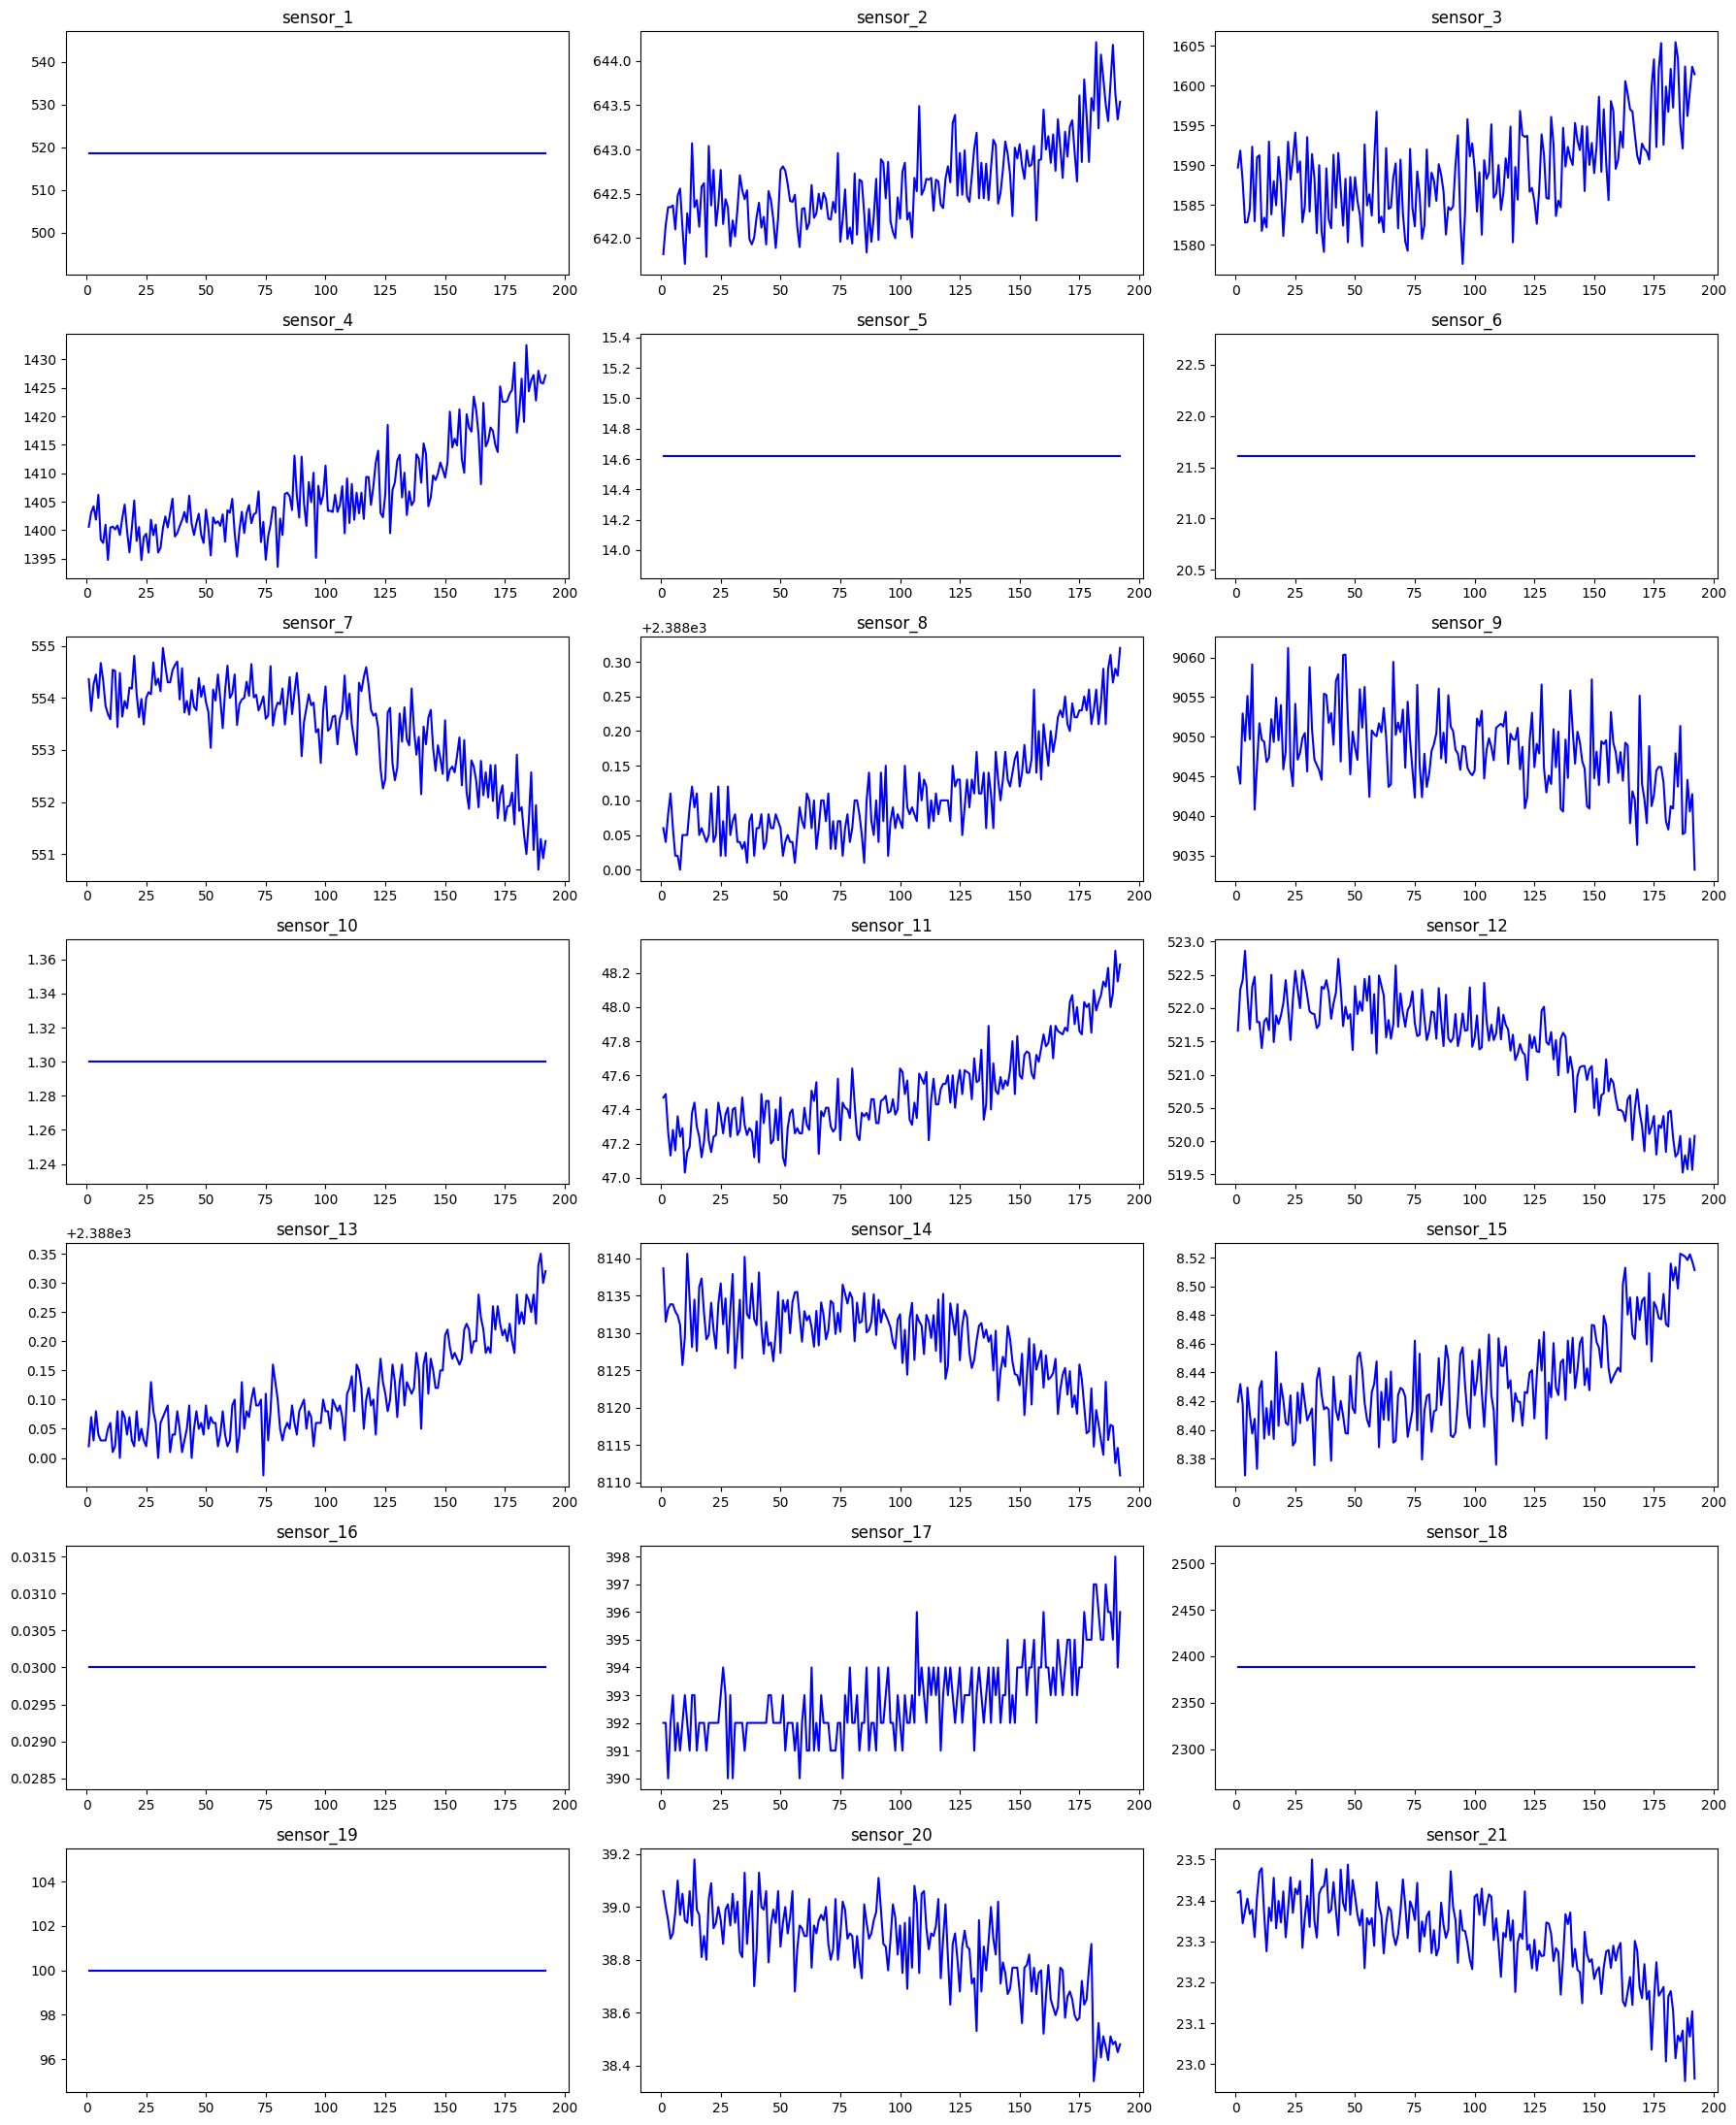

In [3]:
# Analyzing Train Data
# Calculating Standard Deviations
sensor_columns = [col for col in train_df.columns if col.startswith('sensor_')]
train_std = train_df[sensor_columns].std().sort_values()
print("--- Sensor Standard Deviation (Train Data) ---")
print(train_std)

# Plotting Individual Sensor Graphs
print(f"\nIndividual Sensor Plots for Engine ID: 1 (Train Data)")
train_engine_df = train_df[train_df['unit_nr'] == 1]
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(18, 22))
axes = axes.flatten()
for i, sensor in enumerate(sensor_columns):
    ax = axes[i]
    sns.lineplot(data=train_engine_df, x='time_cycles', y=sensor, ax=ax, color='blue')
    ax.set_title(sensor)
    ax.set_xlabel('')
    ax.set_ylabel('')
for j in range(len(sensor_columns), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

--- Sensor Standard Deviation (Test Data) ---
sensor_1     0.000000e+00
sensor_18    0.000000e+00
sensor_19    0.000000e+00
sensor_16    1.040874e-17
sensor_10    2.220531e-16
sensor_5     1.776425e-15
sensor_6     1.704085e-03
sensor_15    2.900933e-02
sensor_13    5.693431e-02
sensor_8     5.744178e-02
sensor_21    8.412028e-02
sensor_20    1.416808e-01
sensor_11    1.959172e-01
sensor_2     4.008993e-01
sensor_12    5.596268e-01
sensor_7     6.812861e-01
sensor_17    1.233577e+00
sensor_3     5.003274e+00
sensor_4     6.688309e+00
sensor_14    1.018860e+01
sensor_9     1.143626e+01
dtype: float64

Individual Sensor Plots for Engine ID: 1 (Test Data)


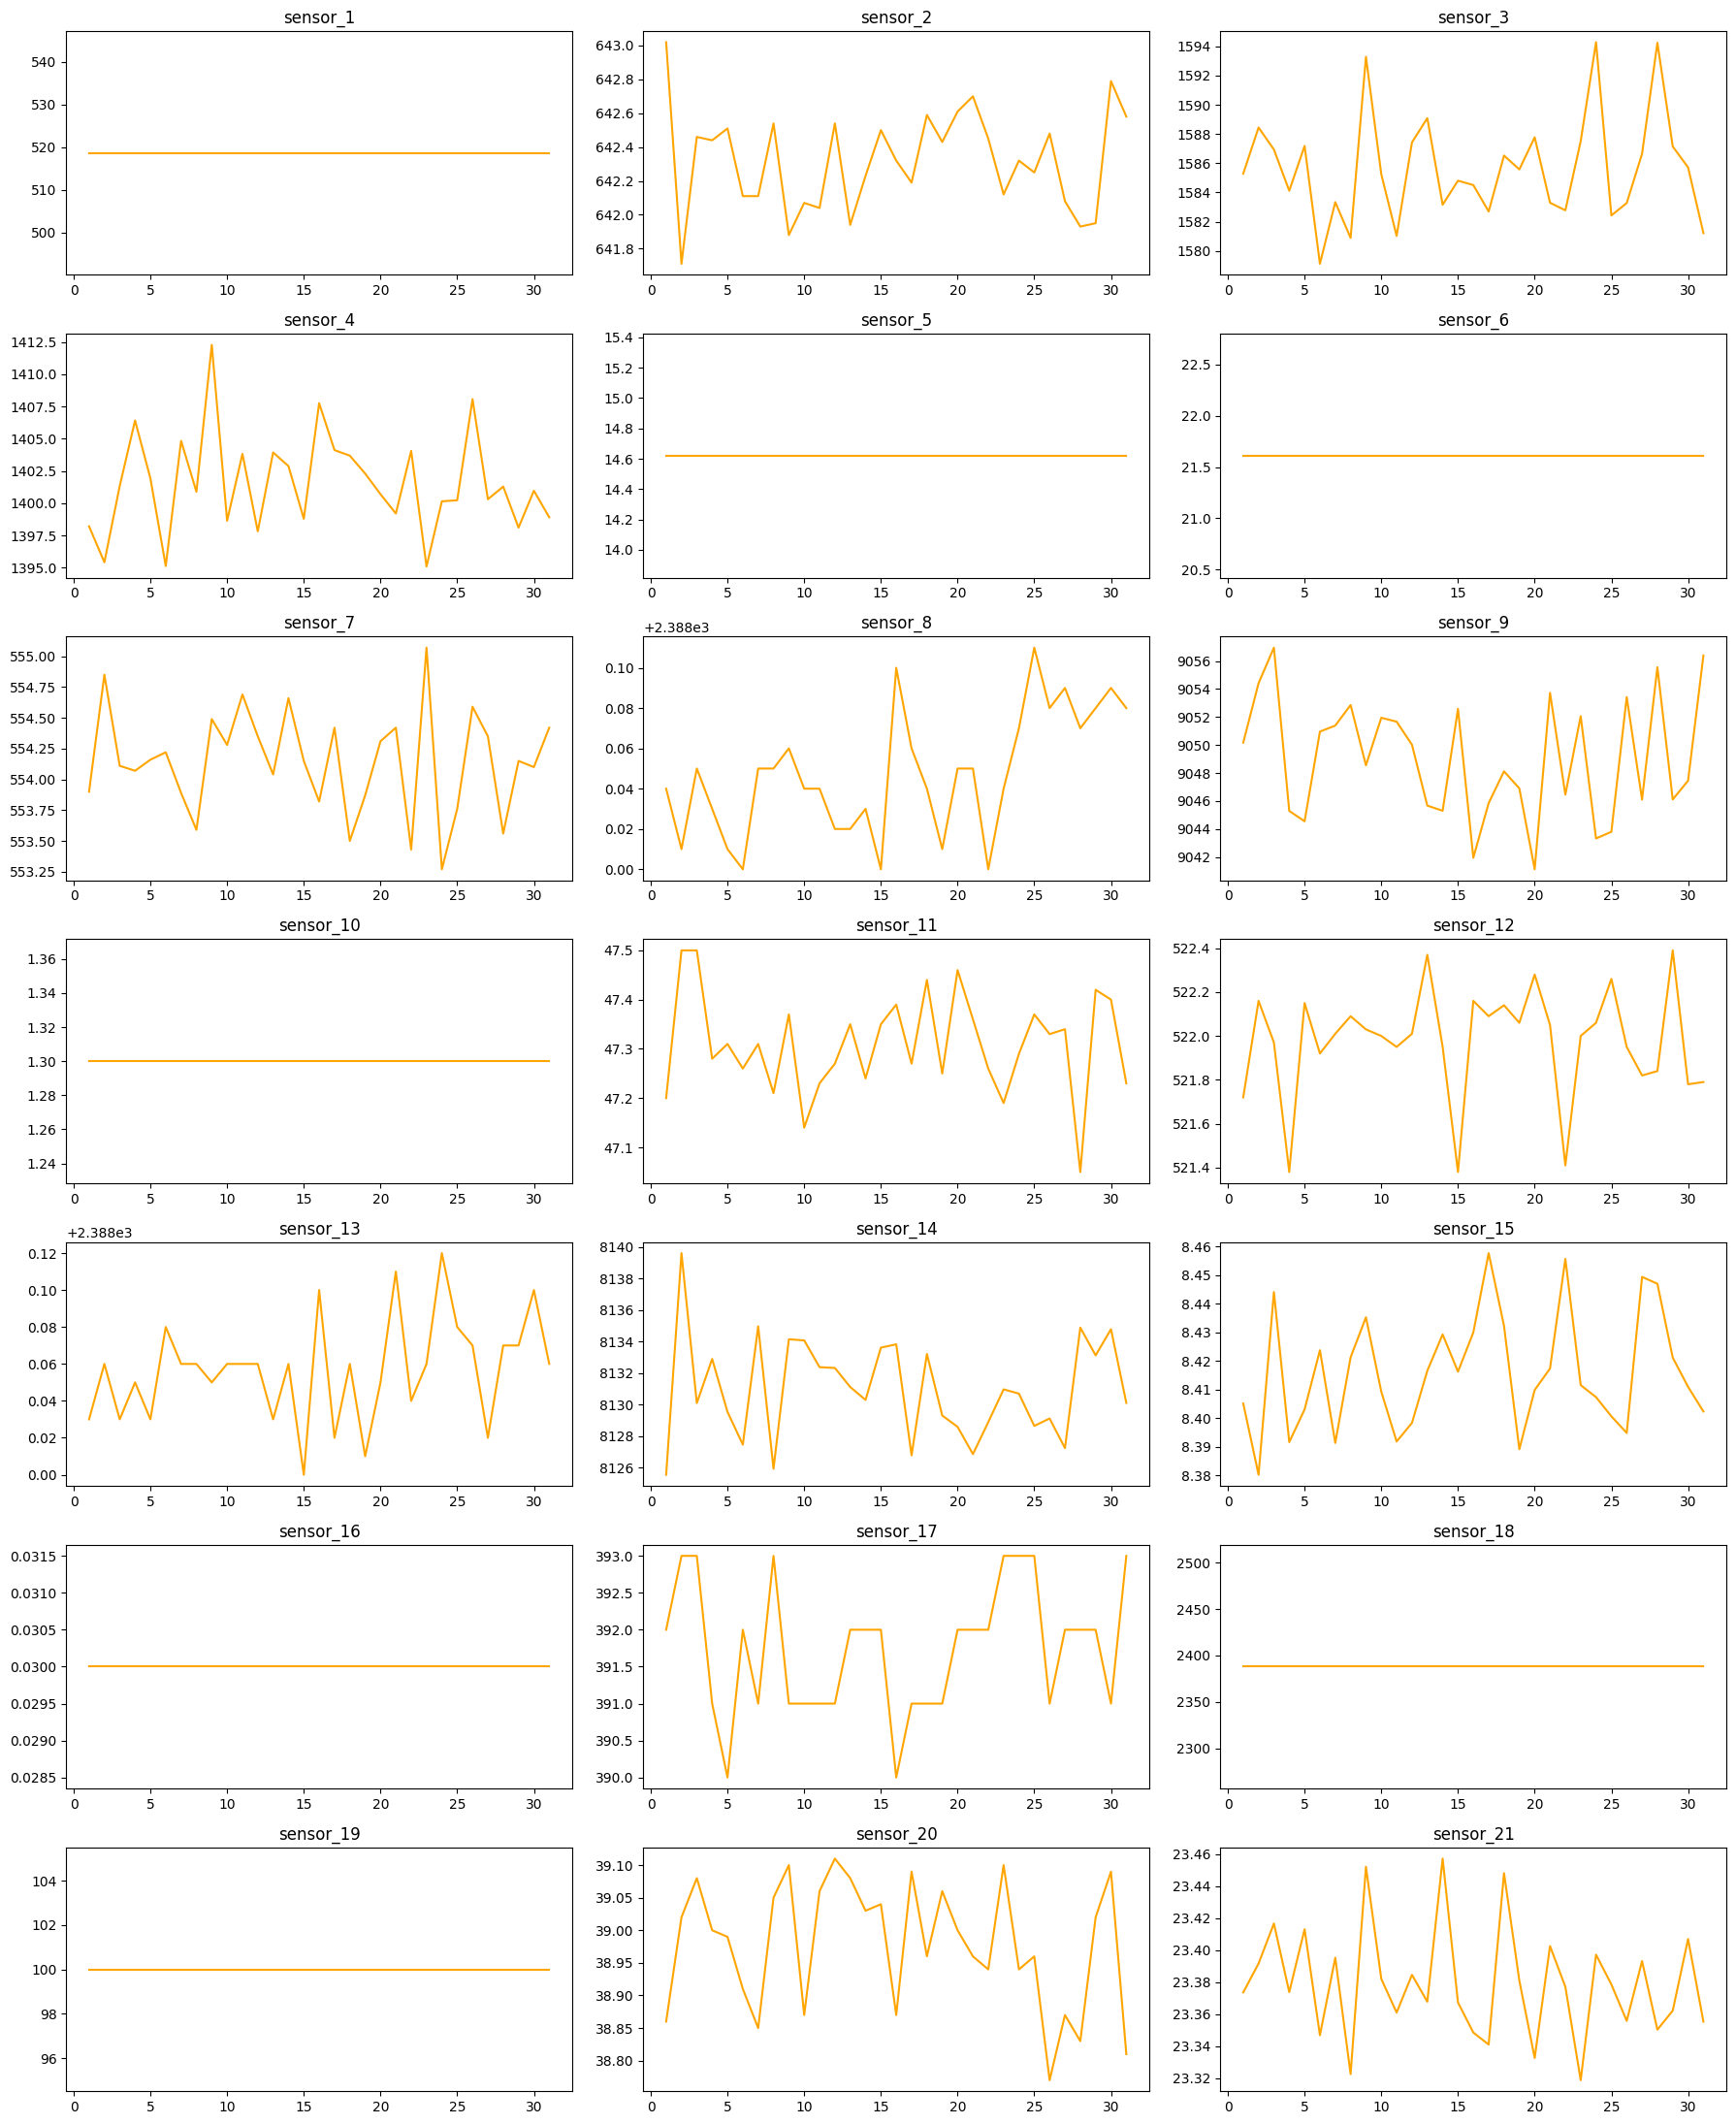

In [4]:
# Analyzing Test Data
# Calculating Standard Deviations ---
test_sensor_columns = [col for col in test_df.columns if col.startswith('sensor_')]
if test_sensor_columns:
    test_std = test_df[test_sensor_columns].std().sort_values()
    print("--- Sensor Standard Deviation (Test Data) ---")
    print(test_std)

    # Plotting Individual Sensor Graphs
    print(f"\nIndividual Sensor Plots for Engine ID: 1 (Test Data)")
    test_engine_df = test_df[test_df['unit_nr'] == 1]
    fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(18, 22))
    axes = axes.flatten()
    for i, sensor in enumerate(test_sensor_columns):
        ax = axes[i]
        sns.lineplot(data=test_engine_df, x='time_cycles', y=sensor, ax=ax, color='orange')
        ax.set_title(sensor)
        ax.set_xlabel('')
        ax.set_ylabel('')
    for j in range(len(test_sensor_columns), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
else:
    print("No sensor columns found in the test data.")

In [5]:
# Feature Engineering and Preprocessing

# Identify and Drop Useless Sensors
useless_sensors = train_std[train_std < 0.01].index.tolist()
print(f"\nIdentified {len(useless_sensors)} useless sensors based on training data variance:")
print(useless_sensors)

# Calculating RUL for Training Data
max_cycles = train_df.groupby('unit_nr')['time_cycles'].max()
train_df['RUL'] = train_df.groupby('unit_nr')['time_cycles'].transform(lambda x: x.max() - x)

# Drop Useless Columns 
train_df_filtered = train_df.drop(columns=useless_sensors)
test_df_filtered = test_df.drop(columns=useless_sensors)

# Create Final Datasets and Scale
feature_cols = [col for col in train_df_filtered.columns if col in test_df_filtered.columns]
feature_cols = [col for col in feature_cols if col not in ['unit_nr', 'time_cycles', 'RUL']]

X_train = train_df_filtered[feature_cols]
y_train = train_df_filtered['RUL']

# Select only the last time step for each engine in the test set
X_test = test_df_filtered.groupby('unit_nr').last()[feature_cols]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

print("\n--- Final Scaled Training Data ---")
print(X_train_scaled.head())

print("\n--- Final Scaled Test Data ---")
print(X_test_scaled.head())


Identified 7 useless sensors based on training data variance:
['sensor_1', 'sensor_10', 'sensor_19', 'sensor_18', 'sensor_16', 'sensor_5', 'sensor_6']

--- Final Scaled Training Data ---
   op_setting_1  op_setting_2  op_setting_3  sensor_2  sensor_3  sensor_4  \
0      0.459770      0.166667           0.0  0.183735  0.406802  0.309757   
1      0.609195      0.250000           0.0  0.283133  0.453019  0.352633   
2      0.252874      0.750000           0.0  0.343373  0.369523  0.370527   
3      0.540230      0.500000           0.0  0.343373  0.256159  0.331195   
4      0.390805      0.333333           0.0  0.349398  0.257467  0.404625   

   sensor_7  sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  sensor_14  \
0  0.726248  0.242424  0.109755   0.369048   0.633262   0.205882   0.199608   
1  0.628019  0.212121  0.100242   0.380952   0.765458   0.279412   0.162813   
2  0.710145  0.272727  0.140043   0.250000   0.795309   0.220588   0.171793   
3  0.740741  0.318182  0.124518  

In [6]:
# Train and Evaluate a Baseline Model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining the model...")
model.fit(X_train_scaled, y_train)
print("Model training complete!")

# Make Predictions
print("\nMaking predictions on the test data...")
rul_predictions = model.predict(X_test_scaled)

# Evaluate the Model's Performance 
truth_path = os.path.join('..', 'data', 'FD001', 'RUL_FD001.txt')
truth_df = pd.read_csv(truth_path, header=None)
true_rul = truth_df[0]

rmse = np.sqrt(mean_squared_error(true_rul, rul_predictions))
print(f"\nModel Performance (RMSE): {rmse:.2f}")

# Display Sample Predictions
print("\nFirst 10 Predictions vs. True RUL:")
for i in range(10):
    print(f"Engine {i+1}: Predicted RUL = {rul_predictions[i]:.0f}, True RUL = {true_rul[i]}")


Training the model...
Model training complete!

Making predictions on the test data...

Model Performance (RMSE): 34.60

First 10 Predictions vs. True RUL:
Engine 1: Predicted RUL = 166, True RUL = 112
Engine 2: Predicted RUL = 146, True RUL = 98
Engine 3: Predicted RUL = 57, True RUL = 69
Engine 4: Predicted RUL = 112, True RUL = 82
Engine 5: Predicted RUL = 122, True RUL = 91
Engine 6: Predicted RUL = 117, True RUL = 93
Engine 7: Predicted RUL = 131, True RUL = 91
Engine 8: Predicted RUL = 116, True RUL = 95
Engine 9: Predicted RUL = 121, True RUL = 111
Engine 10: Predicted RUL = 126, True RUL = 96


# LSTM

In [7]:
# Imports for Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [8]:
# Reshape Data for LSTM

# LSTMs expect data in the shape: [samples, time_steps, features].
# We need a function to create sequences (or "windows") from our data.

# Align indices to prevent UserWarning during boolean filtering
train_df_filtered.reset_index(drop=True, inplace=True)
X_train_scaled.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
test_df_filtered.reset_index(drop=True, inplace=True)
X_test_scaled.reset_index(drop=True, inplace=True)

# Clip the RUL values to focus the model on the period closer to failure.
y_train = y_train.clip(upper=125)

# Scale the target variable (y_train)
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))


def create_sequences(input_data, target_data, sequence_length):
    X_sequences, y_sequences = [], []
    for i in range(len(input_data) - sequence_length + 1):
        X_sequences.append(input_data[i:(i + sequence_length)])
        y_sequences.append(target_data[i + sequence_length - 1])
    return np.array(X_sequences), np.array(y_sequences)

# Define the sequence length (how many time steps to look back)
sequence_length = 50

# The training data needs to be grouped by engine to create sequences correctly
X_train_reshaped, y_train_reshaped = [], []

for unit_nr in train_df_filtered['unit_nr'].unique():
    unit_data = X_train_scaled[train_df_filtered['unit_nr'] == unit_nr]
    unit_target = y_train_scaled[train_df_filtered['unit_nr'] == unit_nr]
    
    X, y = create_sequences(unit_data.values, unit_target, sequence_length)
    if X.shape[0] > 0:
        X_train_reshaped.append(X)
        y_train_reshaped.append(y)

X_train_final = np.concatenate(X_train_reshaped)
y_train_final = np.concatenate(y_train_reshaped)

# For the test data, we only need the last sequence for each engine
X_test_reshaped = []
for unit_nr in test_df_filtered['unit_nr'].unique():
    unit_data = X_test_scaled[test_df_filtered['unit_nr'] == unit_nr]
    
    last_sequence_values = unit_data.values
    
    if len(last_sequence_values) < sequence_length:
        padding_shape = (sequence_length - len(last_sequence_values), last_sequence_values.shape[1])
        padding = np.zeros(padding_shape)
        last_sequence = np.concatenate([padding, last_sequence_values])
    else:
        last_sequence = last_sequence_values[-sequence_length:]
        
    X_test_reshaped.append(last_sequence)

X_test_final = np.array(X_test_reshaped)

print("--- Data Reshaped for LSTM ---")
print("Training data shape:", X_train_final.shape)
print("Test data shape:", X_test_final.shape)


--- Data Reshaped for LSTM ---
Training data shape: (15731, 50, 17)
Test data shape: (100, 50, 17)


C:\Users\Dell\AppData\Local\Temp\ipykernel_20156\2749806128.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unit_data = X_test_scaled[test_df_filtered['unit_nr'] == unit_nr]
C:\Users\Dell\AppData\Local\Temp\ipykernel_20156\2749806128.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unit_data = X_test_scaled[test_df_filtered['unit_nr'] == unit_nr]
C:\Users\Dell\AppData\Local\Temp\ipykernel_20156\2749806128.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unit_data = X_test_scaled[test_df_filtered['unit_nr'] == unit_nr]
C:\Users\Dell\AppData\Local\Temp\ipykernel_20156\2749806128.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unit_data = X_test_scaled[test_df_filtered['unit_nr'] == unit_nr]
C:\Users\Dell\AppData\Local\Temp\ipykernel_20156\2749806128.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unit_data =

In [9]:
# Build and Train the LSTM Model

model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

# Train the model for fewer epochs to make it manageable
print("\nTraining the LSTM model...")
history = model_lstm.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
print("Model training complete!")

c:\Users\Dell\Desktop\Uniconverge\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        47,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,451 (302.54 KB)

 Trainable params: 77,451 (302.54 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model...
Epoch 1/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - loss: 0.0327 - val_loss: 0.0149
Epoch 2/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 3/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - loss: 0.0140 - val_loss: 0.0105
Epoch 4/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - loss: 0.0128 - val_loss: 0.0172
Epoch 5/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - loss: 0.0121 - val_loss: 0.0135
Epoch 6/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - loss: 0.0113 - val_loss: 0.0132
Epoch 7/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - loss: 0.0113 - val_loss: 0.0125
Epoch 8/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - loss: 0.0106 - val_loss: 0.0138
Epoch 9/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - loss: 0.0107 - val_loss: 0.0131
Epoch 10/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - loss: 0.0097 - val_loss: 0.0155
Epoch 11/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - loss: 0.0097 - val_loss: 0.0139
Ep

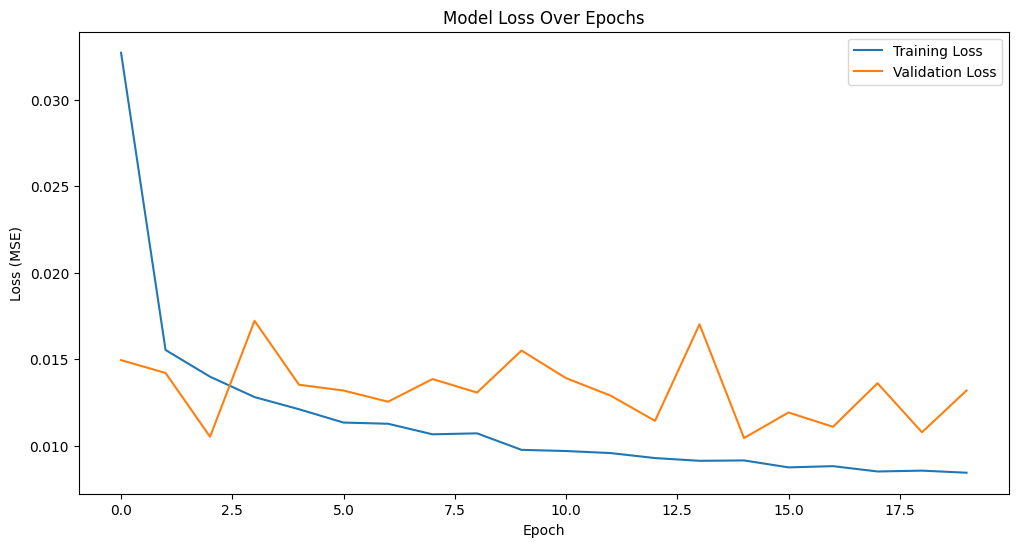


Making predictions with LSTM model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step

LSTM Model Performance (RMSE): 80.64

First 10 Predictions vs. True RUL (LSTM):
Engine 1: Predicted RUL = 27, True RUL = 112
Engine 2: Predicted RUL = 138, True RUL = 98
Engine 3: Predicted RUL = 31, True RUL = 69
Engine 4: Predicted RUL = 145, True RUL = 82
Engine 5: Predicted RUL = 145, True RUL = 91
Engine 6: Predicted RUL = 145, True RUL = 93
Engine 7: Predicted RUL = 145, True RUL = 91
Engine 8: Predicted RUL = 145, True RUL = 95
Engine 9: Predicted RUL = 145, True RUL = 111
Engine 10: Predicted RUL = 145, True RUL = 96


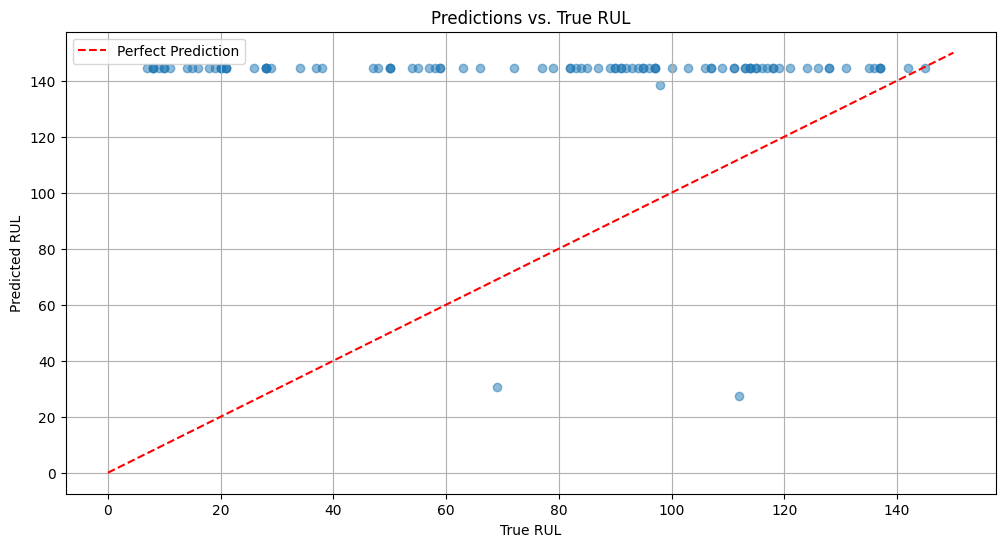

In [10]:
# Evaluate the LSTM Model
# Plot Training History 
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Make predictions on the test data 
print("\nMaking predictions with LSTM model...")
rul_predictions_scaled = model_lstm.predict(X_test_final)

# Inverse transform the predictions to get the actual RUL values
rul_predictions_lstm = target_scaler.inverse_transform(rul_predictions_scaled)

# Calculate the Root Mean Squared Error (RMSE)
rmse_lstm = np.sqrt(mean_squared_error(true_rul, rul_predictions_lstm))
print(f"\nLSTM Model Performance (RMSE): {rmse_lstm:.2f}")

# Display Sample Predictions
print("\nFirst 10 Predictions vs. True RUL (LSTM):")
for i in range(10):
    print(f"Engine {i+1}: Predicted RUL = {rul_predictions_lstm[i][0]:.0f}, True RUL = {true_rul[i]}")

# Visualize Predictions vs. True Values
plt.figure(figsize=(12, 6))
plt.scatter(true_rul, rul_predictions_lstm, alpha=0.5)
plt.plot([0, 150], [0, 150], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predictions vs. True RUL')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()
